In [1]:
import sys
import os
sys.path.append('/home/franzi/anzeigendaten/python_base/skillextraktion/fh_ma')
sys.path.append('/home/franzi/anzeigendaten/EnvPython')
import prepare_training_data
from labels import *
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle
import numpy as np
np.set_printoptions(precision=3)
%precision 3

start = time.time()
x_train, y_train, x_test, y_test, test_afks, features = prepare_training_data.get_training_data()
print('took: ',time.time()-start)

20861874
0
skipgram, punctuation_marks, stoppwords, multiword, lower_case, vector_dim True False False False False 100
init /home/franzi/Documents/models/no_pm_no_sw_vecDim100/skip_gram_model.model
loading existing w2v model from  /home/franzi/Documents/models/no_pm_no_sw_vecDim100/skip_gram_model.model
using data from  /home/franzi/Documents/data/data_4_vecDim100
loading data...
37823 37823 12053 12053 0 0
took:  3.5766522884368896


In [ ]:
import numpy as np
label_y = prepare_training_data.one_hot_to_labels(y_train)

In [4]:
from tensorflow.keras import *

In [5]:
# Build the model
print('Build model...')
from sklearn.neural_network  import MLPClassifier
clf= MLPClassifier(verbose=1, batch_size=32, max_iter=10, learning_rate='adaptive',early_stopping=True)
nsamples, nx, ny = x_train.shape
print(x_train.shape)
x_train2 = x_train.reshape((nsamples,nx*ny))
print(x_train2.shape)
y_train2 = prepare_training_data.one_hot_to_labels(y_train)
clf.fit(x_train2, y_train2)

Build model...
(37823, 9, 100)
(37823, 900)
Iteration 1, loss = 0.62069837
Validation score: 0.821306
Iteration 2, loss = 0.44934499
Validation score: 0.839017
Iteration 3, loss = 0.38110726
Validation score: 0.842189
Iteration 4, loss = 0.32573933
Validation score: 0.839810
Iteration 5, loss = 0.28269130
Validation score: 0.849062
Iteration 6, loss = 0.24154316
Validation score: 0.842982
Iteration 7, loss = 0.20901432
Validation score: 0.844832
Iteration 8, loss = 0.18347715
Validation score: 0.842189
Iteration 9, loss = 0.16414666
Validation score: 0.837431
Iteration 10, loss = 0.14920832
Validation score: 0.840338


MLPClassifier(activation='relu', alpha=0.0001, batch_size=32, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=10,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=1, warm_start=False)

In [7]:

nsamples, nx, ny = x_test.shape
print(x_test.shape)
x_test2 = x_test.reshape((nsamples,nx*ny))
print(x_test2.shape)
# predict test data
y_pred = clf.predict(x_test2)

(12053, 9, 100)
(12053, 900)


In [ ]:
import numpy as np
# convert one hot to labels for test data
pred_label = y_pred
true_label = prepare_training_data.one_hot_to_labels(y_test)

In [9]:
# Calc metrics for test data
import sklearn
from sklearn.metrics import precision_score, recall_score
from tabulate import tabulate
label_list = list(labels.keys())

headers = [l for l in label_list ]
headers = [' '] + headers

table=[['precision'] + list(precision_score(true_label, pred_label, average=None)), 
       ['recall']+list(recall_score(true_label, pred_label, average=None)), 
       ['f1']+ list(sklearn.metrics.f1_score(true_label, pred_label, average=None))]

print(tabulate(table, headers=headers, tablefmt='orgtbl'))
f1 = sklearn.metrics.f1_score(true_label, pred_label, average=None)
f1 = np.delete(f1, 4)
f1 = np.delete(f1, 6)
print('f1 average: ',sum(sklearn.metrics.f1_score(true_label, pred_label, average=None))/len(list(precision_score(true_label, pred_label, average=None))))
print('f1 average: ',sum(f1)/6)
print('Precision average: ',sum(precision_score(true_label, pred_label, average=None)/8))
print('Recall average: ',sum(recall_score(true_label, pred_label, average=None)/8))
print('acc', sklearn.metrics.accuracy_score(true_label, pred_label))

|           |   Ausbildung |    Beruf |   allgemein |   berufsspez |   Sprache |   Technologie |   Softskill |   noSkill |
|-----------+--------------+----------+-------------+--------------+-----------+---------------+-------------+-----------|
| precision |     0.782383 | 0.357143 |    0.422303 |     0.613254 |  0.896226 |      0.768647 |    0.791277 |  0.884451 |
| recall    |     0.820652 | 0.078125 |    0.323983 |     0.579439 |  0.859729 |      0.784516 |    0.707521 |  0.925867 |
| f1        |     0.801061 | 0.128205 |    0.366667 |     0.595867 |  0.877598 |      0.776501 |    0.747059 |  0.904685 |
f1 average:  0.6497053716001369
f1 average:  0.5692266060640668
Precision average:  0.6894606893130063
Recall average:  0.6349790528709964
acc 0.8203766697087862


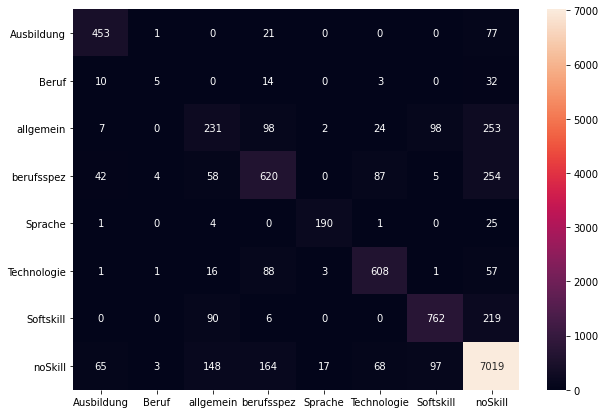

In [10]:
# Create Confusion Matrix

import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = sklearn.metrics.confusion_matrix(true_label, pred_label)
df_cm = pd.DataFrame(cm, labels,columns = labels)
plt.figure(figsize = (10,7))
plt.ylabel('Eingabe')
plt.xlabel('Ausgabe')
sn.heatmap(df_cm, annot=True,fmt='g')

In [11]:
# clean noSkill for evaluation
clean_y_pred = []
clean_y_test = []
true_noSkills = 0
clean_x_test = []
afks = []

for i in range(len(y_test)):
    if(true_label[i] != 7 or pred_label[i] != 7):
        clean_x_test.append(x_test[i])
        clean_y_pred.append(pred_label[i])
        clean_y_test.append(true_label[i])
        afks.append(test_afks[i])
    else:
        true_noSkills += 1
pred_label = clean_y_pred
true_label = clean_y_test
print('correctly labeled noSkills: ', true_noSkills)

correctly labeled noSkills:  7019


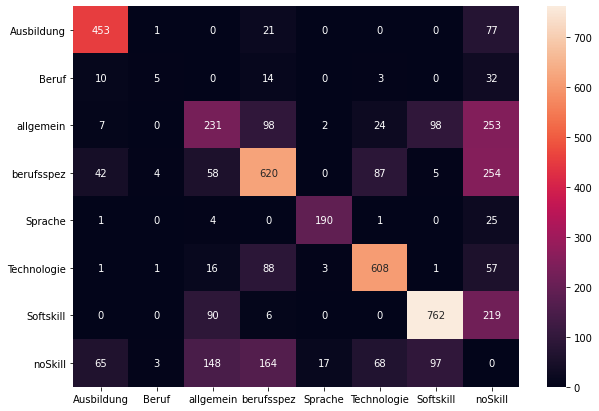

In [12]:
# Create Confusion Matrix

import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = sklearn.metrics.confusion_matrix(true_label, pred_label)
df_cm = pd.DataFrame(cm, labels,columns = labels)
plt.figure(figsize = (10,7))
plt.ylabel('Eingabe')
plt.xlabel('Ausgabe')
sn.heatmap(df_cm, annot=True,fmt='g')